# Digit Recognizer

https://www.kaggle.com/c/digit-recognizer/overview

In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data Loading

In [31]:
from fastai.vision import *

In [32]:
path = Config.data_path()/'digit-recognizer'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/digit-recognizer')

In [33]:
#! pip install kaggle --upgrade

In [34]:
#! rm {path}/*

#! kaggle competitions download -c digit-recognizer -p {path}
#! unzip -q -n {path}/digit-recognizer.zip -d {path}
#! rm {path}/*.zip

#path.ls()

In [35]:
df = pd.read_csv(path/'train.csv', header='infer')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
class NumpyImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28,1)
        return Image(pil2tensor(img, dtype=np.float32))
    
    @classmethod
    def from_csv(cls, path:PathOrStr, csv:str, **kwargs)->'ItemList': 
        df = pd.read_csv(Path(path)/csv, header='infer')
        res = super().from_df(df, path=path, cols=0, **kwargs)
        if 'label' in df.columns:
            df = df.drop('label', axis=1)
        df = np.array(df)/255.
#        mean = df.mean()
#        std = df.std()
#        res.items = (df-mean)/std
        res.items = df
        return res

In [37]:
test = NumpyImageList.from_csv(path, 'test.csv')
tfms = (rand_pad(padding=3, size=28, mode='zeros'), [])
data = (NumpyImageList.from_csv(path, 'train.csv')
        .split_by_rand_pct(.05, seed=42)
        .label_from_df(cols='label')
        .add_test(test, label=0)
        .transform(tfms)
        .databunch(bs=1024, num_workers=0)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (39900 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /home/jupyter/.fastai/data/digit-recognizer;

Valid: LabelList (2100 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,1,9,9,8
Path: /home/jupyter/.fastai/data/digit-recognizer;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/.fastai/data/digit-recognizer

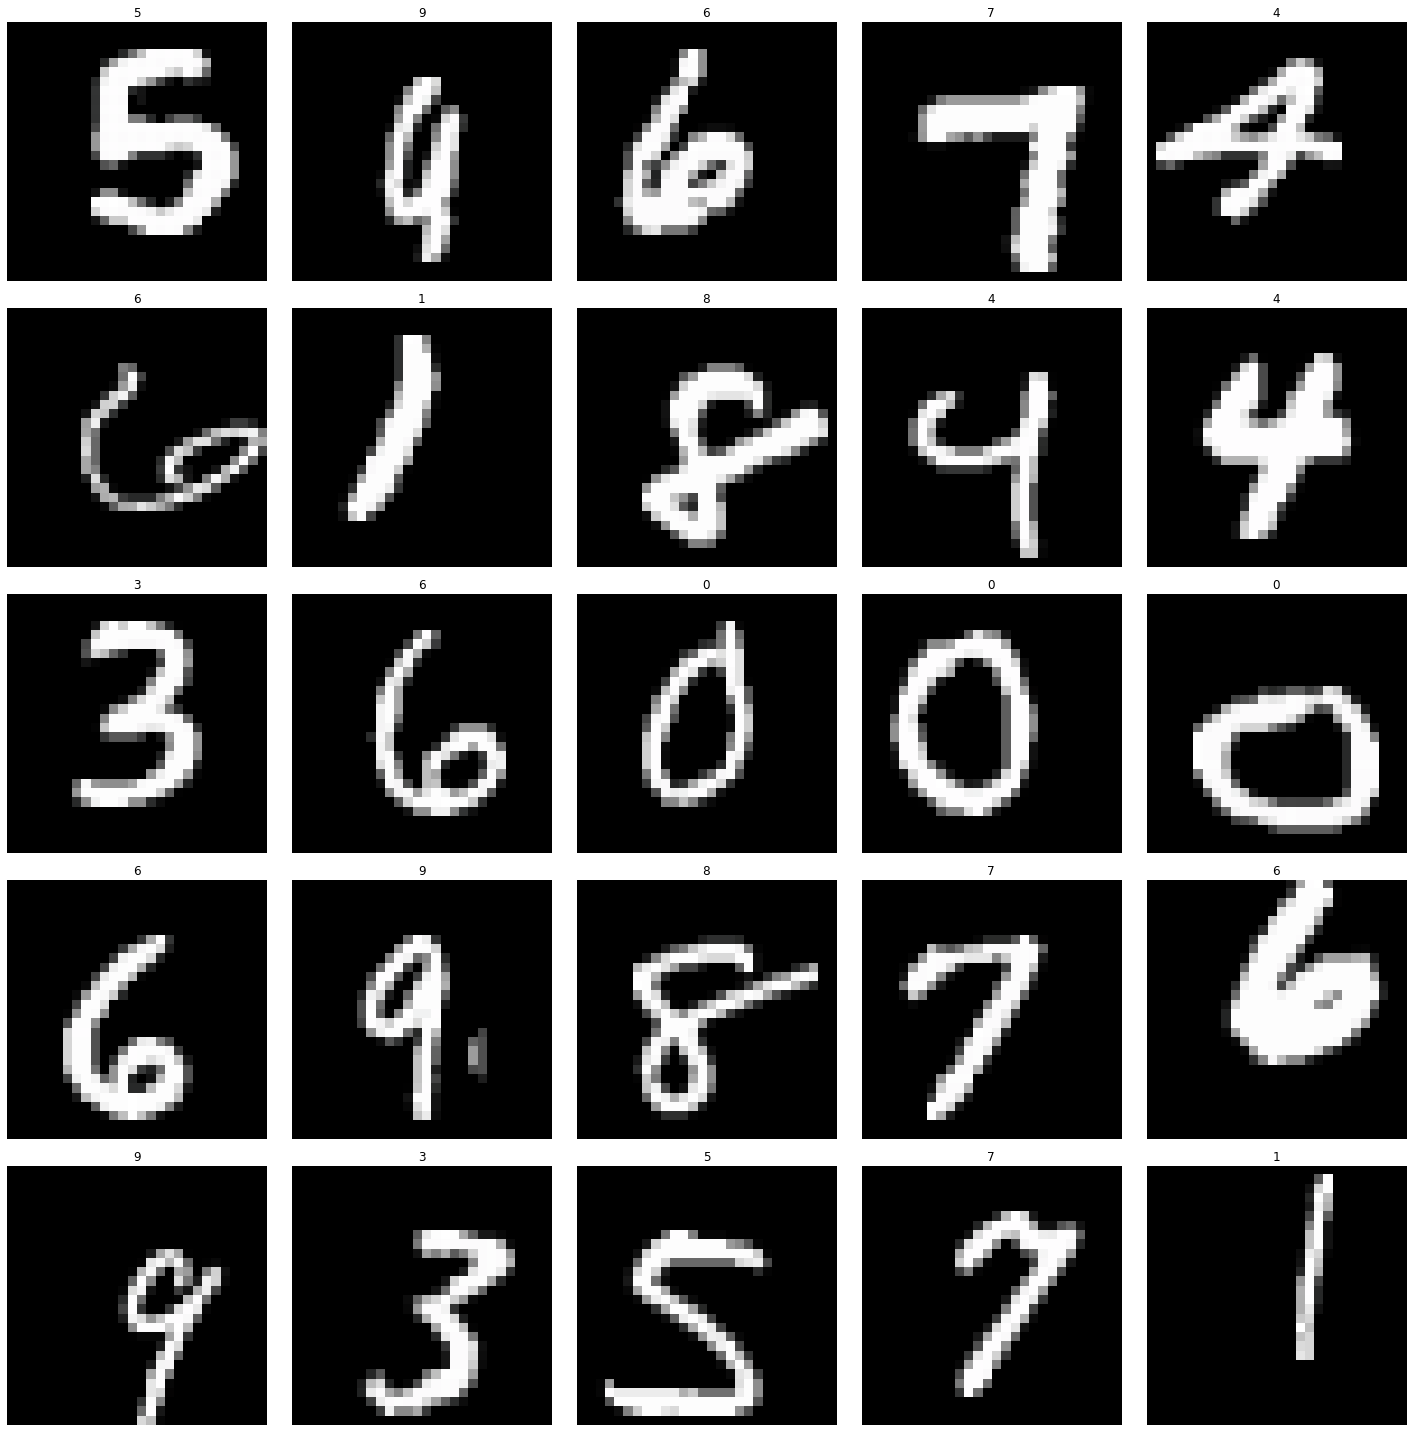

In [38]:
data.show_batch()

# Training

In [39]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 4.37E-02


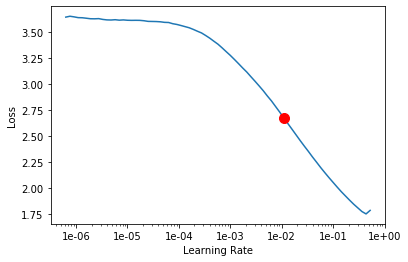

In [41]:
learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(4, slice(1.1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.520645,0.740774,0.229048,00:08
1,0.875503,0.313655,0.098571,00:08
2,0.573529,0.224790,0.070000,00:08
3,0.425741,0.209692,0.063810,00:08


In [43]:
learn.save('3-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 9.12E-04


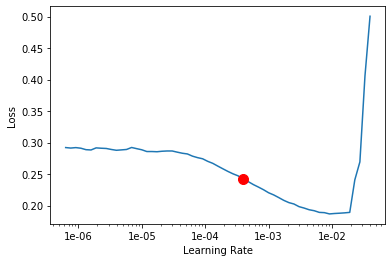

In [44]:
learn.load('3-stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [45]:
learn.fit_one_cycle(4, slice(1e-6, 9e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.270109,0.171884,0.048571,00:09
1,0.213602,0.126775,0.036190,00:09
2,0.171795,0.110399,0.032381,00:09
3,0.150465,0.107468,0.031905,00:09


In [46]:
learn.save('3-stage-2')

## Resnet50

In [10]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


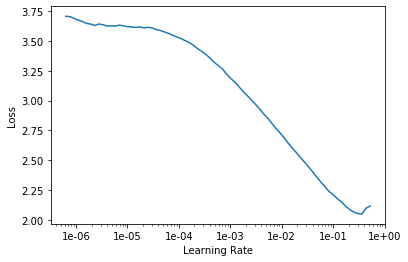

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.510006,0.809852,0.256190,00:13
1,0.978699,0.543390,0.173095,00:13
2,0.616927,0.341584,0.109048,00:13
3,0.407446,0.214336,0.067857,00:13
4,0.273735,0.153952,0.048333,00:13
5,0.219438,0.126930,0.041667,00:13
6,0.179080,0.105416,0.035000,00:13
7,0.154392,0.092992,0.028333,00:13
8,0.145276,0.089506,0.027619,00:12
9,0.136152,0.087562,0.027857,00:13


In [20]:
learn.save('3-stage-1-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


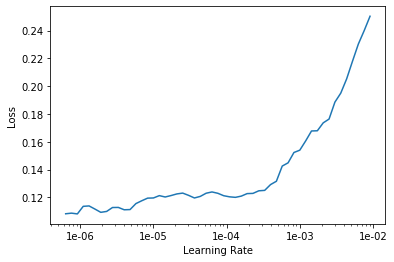

In [11]:
learn.load('3-stage-1-rn50')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(10, slice(1e-6, 2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.136346,0.067943,0.020952,00:15
1,0.119422,0.060960,0.018095,00:15
2,0.100918,0.051053,0.016429,00:15
3,0.086226,0.045599,0.015714,00:15
4,0.071792,0.040812,0.013095,00:15
5,0.057767,0.038430,0.013333,00:15
6,0.049956,0.035832,0.011905,00:15
7,0.046297,0.034296,0.010714,00:15
8,0.047138,0.034839,0.010714,00:15
9,0.045263,0.033935,0.010714,00:15


In [13]:
learn.save('3-stage-2-rn50')

## Resnet101

In [47]:
learn = cnn_learner(data, models.resnet101, metrics=[accuracy,error_rate])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 5.25E-02


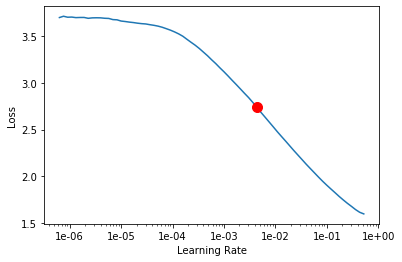

In [48]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [49]:
lr = 4.37e-3
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.907379,1.111084,0.657619,0.342381,00:15
1,1.313067,0.612951,0.812381,0.187619,00:15
2,0.913188,0.379884,0.868571,0.131429,00:15
3,0.656002,0.282192,0.910476,0.089524,00:15
4,0.485738,0.207374,0.930000,0.070000,00:15
5,0.376340,0.171522,0.940952,0.059048,00:15
6,0.301860,0.147389,0.949048,0.050952,00:15
7,0.255822,0.136592,0.950952,0.049048,00:15
8,0.225540,0.131309,0.952857,0.047143,00:15
9,0.211841,0.129643,0.952857,0.047143,00:15


In [50]:
learn.save('3-stage-1-rn101')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.63E-04


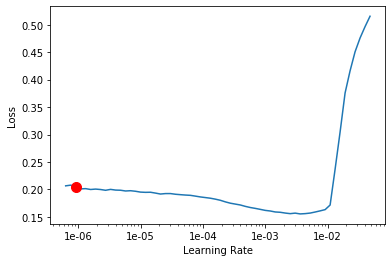

In [51]:
learn.load('3-stage-1-rn101')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.194986,0.120673,0.956667,0.043333,00:19
1,0.171572,0.098146,0.968095,0.031905,00:19
2,0.138208,0.071650,0.974286,0.025714,00:19
3,0.111108,0.055837,0.980476,0.019524,00:19
4,0.088010,0.049064,0.981905,0.018095,00:19
5,0.072992,0.044045,0.984286,0.015714,00:19


In [25]:
learn.save('3-stage-2-rn101')

# Test

In [26]:
learn.load('3-stage-2-rn101')

Learner(data=ImageDataBunch;

Train: LabelList (39900 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /home/jupyter/.fastai/data/digit-recognizer;

Valid: LabelList (2100 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
8,1,9,9,8
Path: /home/jupyter/.fastai/data/digit-recognizer;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/.fastai/data/digit-recognizer, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False

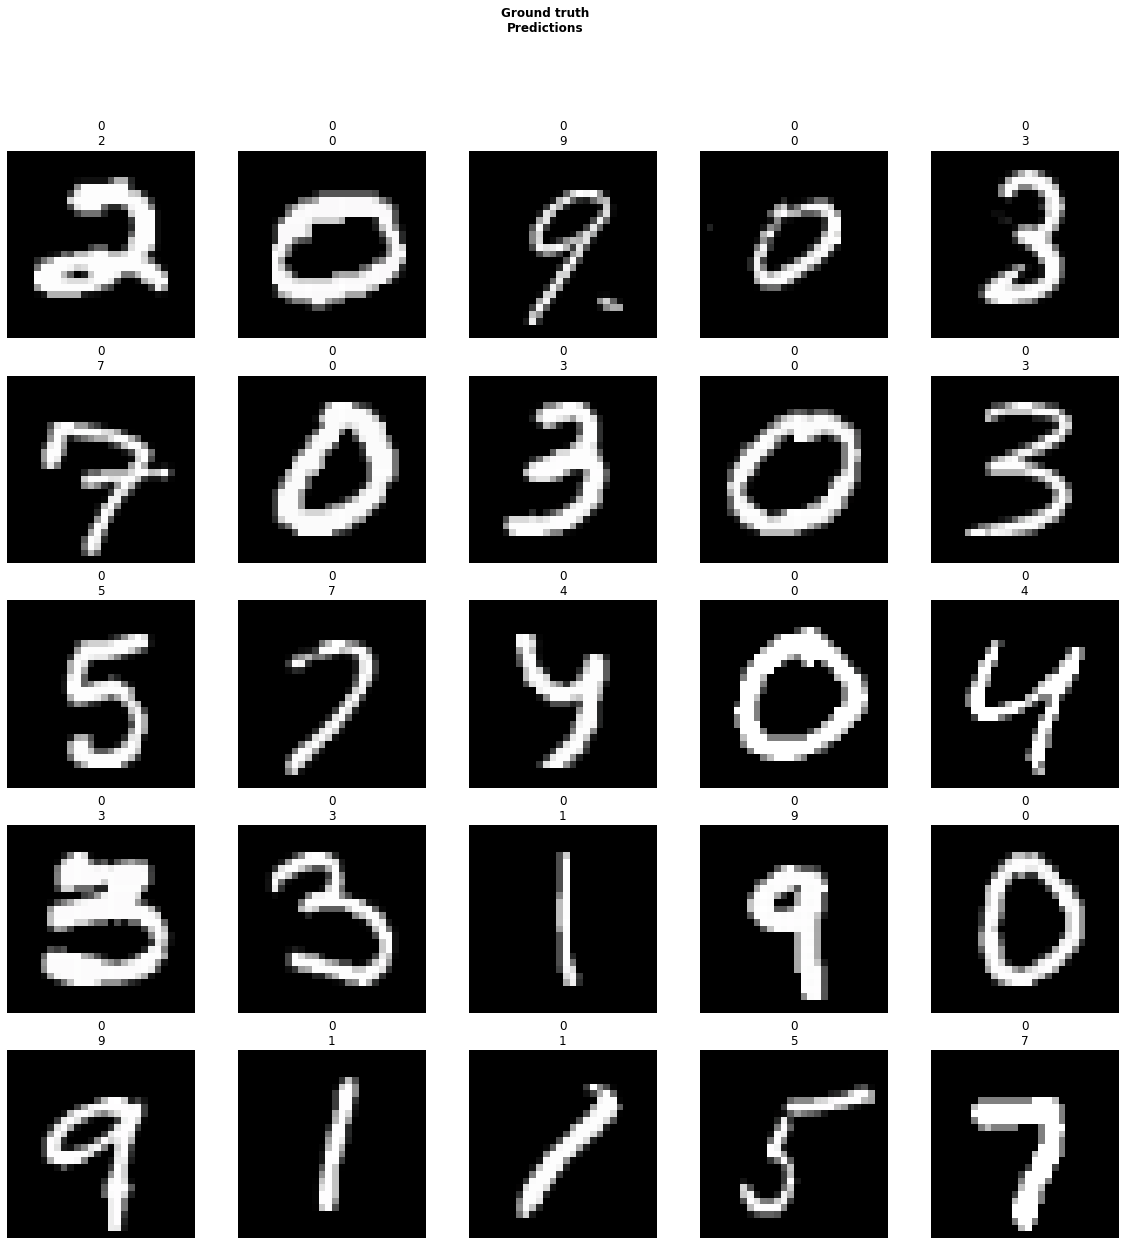

In [27]:
learn.show_results(ds_type=DatasetType.Test)

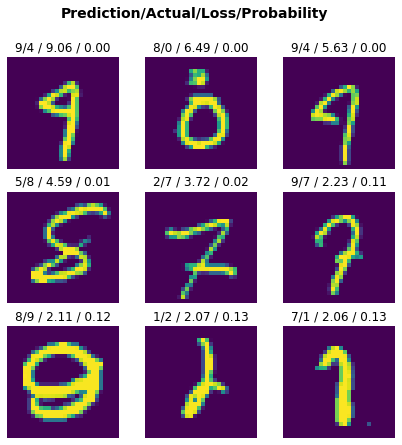

In [29]:
interp = learn.interpret()
interp.plot_top_losses(9, figsize=(7,7))

# Submit to Kaggle

In [31]:
pred_test = learn.get_preds(ds_type=DatasetType.Test)

In [47]:
test_result = torch.argmax(pred_test[0],dim=1).numpy()
test_result, len(result)

(array([2, 0, 9, 0, ..., 7, 3, 9, 2]), 28000)

In [48]:
pd_result = pd.Series(test_result,name='Label')
submission = pd.concat([pd.Series(range(1,28001),name='ImageId'),pd_result],axis=1)
submission.to_csv(path/'submit.csv',index=False)

In [4]:
#!kaggle competitions submit -f {path}/submit.csv -m 'Submission generated with a pretrained Resnet101 model and the fastai library. This is my first Kaggle submission.' digit-recognizer

100%|████████████████████████████████████████| 208k/208k [00:05<00:00, 39.3kB/s]
Successfully submitted to Digit Recognizer